# PRELIMINARIES

In [2]:
# interactive plots setup
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# sympy setup
import sympy as sp
sp.init_printing()
from sympy.vector import *

# ploting customizations
from matplotlib import pyplot as plt
size=16
params = {'legend.fontsize': 'large',
#          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.875,
          'ytick.labelsize': size*0.875,
          'axes.titlepad': 25}
plt.rcParams.update(params)
%matplotlib inline

# numerics
import numpy as np

# to save plots as files and download them
# from google.colab import files

## Credit

Initial version written by [Ivan C. Christov](http://christov.tmnt-lab.org), Purdue University.

# PROBLEM STATEMENT

Inspired by Powers' _Mechanics of Fluids_, Prob. 3.6, consider a two-dimensional flow field with Cartesian velocity vector, $\underline{v} = v_i \underline{e}_i$, components of which are
\begin{align*}
  v_1 &= -c x_1 + 4 c x_2,\\
  v_2 &= -c 4 x_1 - c x_2,\\
  v_3 &= 0,
\end{align*}
where $c>0$ is a suitable dimensional constant.

# SOLUTION


Setup a coordinate system using SymPy's [capabilities](https://docs.sympy.org/latest/modules/vector/fields.html) for our analyical calculations.

In [16]:
from sympy.vector import CoordSys3D, Del
C = CoordSys3D('C') # C.x, C.y, C.z are the coordinates 
                    # C.i, C.j, C.k are the unit vectors
# define the nabla operator
nabla = Del()

Define a velocity vector in terms of the unit vectors of our coordinate system from SymPy.


In [17]:
c = sp.Symbol('c', positive='True')
v = c*(1-(C.y)**2) * C.i + 0 * C.j + 0 * C.k
v = c*C.x * C.i - c*C.y * C.j + 0 * C.k
v = (-c*C.x + 4*c*C.y) * C.i + (-c*4*C.x - c*C.y) * C.j + 0 * C.k
v

## The vorticity, $\nabla\times\underline{v}$

In [18]:
# general expression
vorticity = nabla ^ v # in SymPy ^ is one way to denote a cross product
                      # (also used in some books), instead of \times

# evaluated expression
vorticity.doit()

## Kinematic quantities and how they are related, $\nabla\underline{v}$

SymPy doesn't have built-in functionality for gradient of a vector (yet). But you can take a [derivative of a vector with respect to a vector](https://docs.sympy.org/latest/modules/tensor/array.html#derivatives-by-array) (like a "Jacobian").

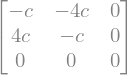

In [19]:
# we need to express the vector via an array of components for the next step
# so, take the dot product of v with each coord vector to get the 3 components
# in SymPy, & is one way to form a dot product
v_array = [ v & C.i, v & C.j, v & C.k ]

gradv = sp.derive_by_array(v_array, [C.x, C.y, C.z])

# convert v and grad v to SymPy matrices
v_array = sp.Matrix(v_array)
gradv = sp.Matrix(gradv)
gradv

Now, we can compute the symmetric part of the velocity gradient.

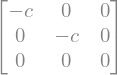

In [20]:
# 1/2 is a float, Rational(1,2) is a symbolic expression for 1/2,
# which lets SymPy do algebra more easily
Sij = sp.Rational(1,2)*(gradv + gradv.transpose())
Sij

The shear rate is defined using a [double contraction](https://docs.sympy.org/latest/modules/tensor/array.html#products-and-contractions) of $S_{ij}$, which we implement as:

In [21]:
SS = sp.sqrt(sp.tensorcontraction(sp.tensorcontraction(sp.tensorproduct(Sij,Sij), (1, 2)), (0, 1)))
SS.simplify()

Now, compute the anti-symmetric part of the velocity gradient.


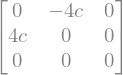

In [22]:
Omegaij = sp.Rational(1,2)*(gradv - gradv.transpose())
Omegaij

Next, compute the _dual vector_ $d_k$ of $\Omega_{ij}$ from the definition given in Panton's Eq. (3.7.4). Verify that $d_k = \omega_k$.

We could use fancy double contraction operations (but I had a hard time figuring it out in the context of $\epsilon_{ijl}$ in SymPy).

So let's brute-force it with some loops.

In [23]:
# initialize as a zero matrix
dvec = sp.Matrix([0,0,0])

for i in 1,2,3:
  dvec[i-1,0] = 0
  for j in 1,2,3:
    for k in 1,2,3:
      dvec[i-1,0] = dvec[i-1,0] + sp.LeviCivita(i,j,k)*Omegaij[j-1,k-1]

d = dvec[0,0] * C.i + dvec[1,0] * C.j + dvec[2,0] * C.k
d

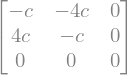

In [24]:
gradv

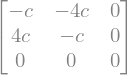

In [25]:
Sij + Omegaij

Verify that the kinematic decomposition, $\partial_i v_j = S_{ij} + \Omega_{ij}$ works.

In [26]:
gradv == Sij + Omegaij

True

## Material derivative of the velocity, $\underline{v}\cdot\nabla\underline{v}$.


First, using the directional derivative interpretation as $v_j\partial_j v_i = (v_j\partial_j)v_i = (\underline{v}\cdot\nabla)\underline{v}$ and [SymPy vector calculus](https://docs.sympy.org/latest/modules/vector/fields.html#directional-derivative).

In [60]:
# in SymPy, & is one way to form a dot product
vdotgradv = (v & nabla)(v)
vdotgradv

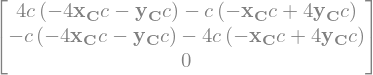

In [64]:
# reprint it as a vertical array for easier reading
vdotgradv_array = sp.Matrix([ [vdotgradv & C.i], [vdotgradv & C.j], [vdotgradv & C.k] ])
vdotgradv_array

Second, using the matrix-vector product interpretation as $ v_j \partial_j v_i = (\partial_j v_i)v_j = [\nabla\underline{v}]^{\rm T} \underline{v}$.

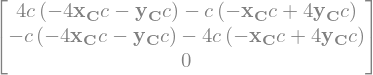

In [65]:
gradv.transpose() * v_array

Verify the first and second methods agree.

In [67]:
vdotgradv_array == gradv.transpose() * v_array

True

You can check that the vesion without the transpose doesn't give the same (right) answer.

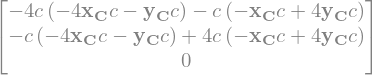

In [69]:
gradv * v_array

In [70]:
vdotgradv_array == gradv * v_array

False

## The volume rate of expansion, $\nabla\cdot\underline{v}$

In [71]:
# general expression
divv = nabla & v

# evaluated expression
divv.doit()